In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

96


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique
0,81a2ece2533bc46a8f1e79c5de042d1662f8cd57,inter-upas,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/excellent-format-few.txt,cq.txt,auto/cte.json,...,3,0.570000,0.661642,0.63,0.721290,0.61,0.700357,0.47,0.563279,cte
1,4ab31df61c1b5d19d505e6e783d5700561471029,perdu-nosh,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/excellent-format-few.txt,cq.txt,auto/cte.json,...,2,0.583333,0.709780,0.61,0.749286,0.63,0.747667,0.51,0.632386,cte
2,5b71034bf974f091f68259beb268d7103903cf40,loose-tipi,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/excellent-format-few.txt,cq.txt,auto/cte.json,...,1,0.603333,0.715038,0.60,0.732118,0.65,0.752948,0.56,0.660048,cte
3,ef5efb019a254d4e898c2e156e98fc1a2aedafbc,fixed-mina,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/excellent-format-few.txt,cq.txt,auto/cte.json,...,3,0.606667,0.731851,0.61,0.728844,0.69,0.808881,0.52,0.657827,cte
4,4054b41ba1c004aaca467c3e447d58606b171415,lento-pons,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,0.7,cte/excellent-format-few.txt,cq.txt,auto/cte.json,...,1,0.636667,0.756616,0.62,0.760633,0.75,0.843524,0.54,0.665693,cte


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [5]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) != 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,params.run
17,cte,cte/excellent-format-few.txt,cq.txt,auto/cte.json,2,0.7,"(1,)"
24,direct,direct/helpful-output-format-few.txt,cq.txt,auto/direct.json,1,0.7,"(2, 3)"


In [6]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [7]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
57,cte,cte/excellent-format-few,cq,auto/cte,6,0.1,0.643333,0.763477,0.66,0.798352,0.71,0.808095,0.56,0.683984
50,cte,cte/excellent-format-few,cq,auto/cte,2,0.1,0.643333,0.761817,0.62,0.763817,0.75,0.830579,0.56,0.691056
56,cte,cte/excellent-format-few,cq,auto/cte,6,0.1,0.633333,0.760087,0.65,0.792482,0.70,0.807203,0.55,0.680575
52,cte,cte/excellent-format-few,cq,auto/cte,3,0.1,0.643333,0.759088,0.61,0.751017,0.75,0.845453,0.57,0.680794
48,cte,cte/excellent-format-few,cq,auto/cte,2,0.1,0.636667,0.758797,0.62,0.755532,0.74,0.829488,0.55,0.691369
58,cte,cte/excellent-format-few,cq,auto/cte,9,0.1,0.626667,0.758452,0.66,0.801840,0.68,0.796619,0.54,0.676898
55,cte,cte/excellent-format-few,cq,auto/cte,6,0.1,0.630000,0.757622,0.66,0.795234,0.69,0.805958,0.54,0.671675
49,cte,cte/excellent-format-few,cq,auto/cte,2,0.1,0.646667,0.757328,0.62,0.751817,0.75,0.823913,0.57,0.696254
54,cte,cte/excellent-format-few,cq,auto/cte,3,0.1,0.643333,0.756903,0.61,0.741920,0.74,0.835430,0.58,0.693359
51,cte,cte/excellent-format-few,cq,auto/cte,2,0.7,0.636667,0.756616,0.62,0.760633,0.75,0.843524,0.54,0.665693


In [8]:
df['params.qa.system_prompt'].unique()

array(['ccot/format-thought', 'cot/format-thought',
       'cte/excellent-format-few', 'direct/helpful-output-format-few'],
      dtype=object)

In [9]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,0.577778,0.681524,0.640000,0.750971,0.600000,0.677548,0.493333,0.616053
1,ccot,ccot/format-thought,cq,auto/ccot,1,0.1,0.626667,0.724480,0.636667,0.750416,0.706667,0.774627,0.536667,0.648397
2,ccot,ccot/format-thought,cq,auto/ccot,2,0.1,0.608889,0.708503,0.623333,0.738413,0.666667,0.746661,0.536667,0.640437
3,ccot,ccot/format-thought,cq,auto/ccot,3,0.1,0.641111,0.741250,0.650000,0.765191,0.683333,0.761265,0.590000,0.697294
4,ccot,ccot/format-thought,cq,auto/ccot,6,0.1,0.636667,0.734519,0.640000,0.757541,0.676667,0.750228,0.593333,0.695789


In [10]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
19,cte,cte/excellent-format-few,cq,auto/cte,6,0.1,0.635556,0.760395,0.656667,0.795356,0.700000,0.807085,0.550000,0.678744
3,ccot,ccot/format-thought,cq,auto/ccot,3,0.1,0.641111,0.741250,0.650000,0.765191,0.683333,0.761265,0.590000,0.697294
29,direct,direct/helpful-output-format-few,cq,auto/direct,6,0.1,0.622222,0.733165,0.623333,0.759019,0.680000,0.752190,0.563333,0.688286
9,cot,cot/format-thought,cq,auto/cot,3,0.1,0.608889,0.702671,0.666667,0.769139,0.646667,0.722143,0.513333,0.616730


## Visualizations

In [11]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["n_shot"].map(str)
    )

    return dataf


In [12]:
def plot_variance(dataf, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [13]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
zero_shot_mask = prepared_df["few_shot_examples"] == 'empty'
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt
0,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,1,0.570000,0.671448,ccot/format-thought | cq | 0
1,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,2,0.576667,0.687011,ccot/format-thought | cq | 0
2,ccot,ccot/format-thought,cq,auto/ccot,0,0.1,3,0.586667,0.686113,ccot/format-thought | cq | 0
3,ccot,ccot/format-thought,cq,auto/ccot,1,0.1,1,0.633333,0.730231,ccot/format-thought | cq | 1
4,ccot,ccot/format-thought,cq,auto/ccot,1,0.1,2,0.620000,0.716818,ccot/format-thought | cq | 1
...,...,...,...,...,...,...,...,...,...,...
91,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.1,2,0.606667,0.716138,direct/helpful-output-format-few | cq | 9
92,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.1,3,0.616667,0.722911,direct/helpful-output-format-few | cq | 9
93,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.7,1,0.616667,0.729136,direct/helpful-output-format-few | cq | 9
94,direct,direct/helpful-output-format-few,cq,auto/direct,9,0.7,2,0.613333,0.721349,direct/helpful-output-format-few | cq | 9


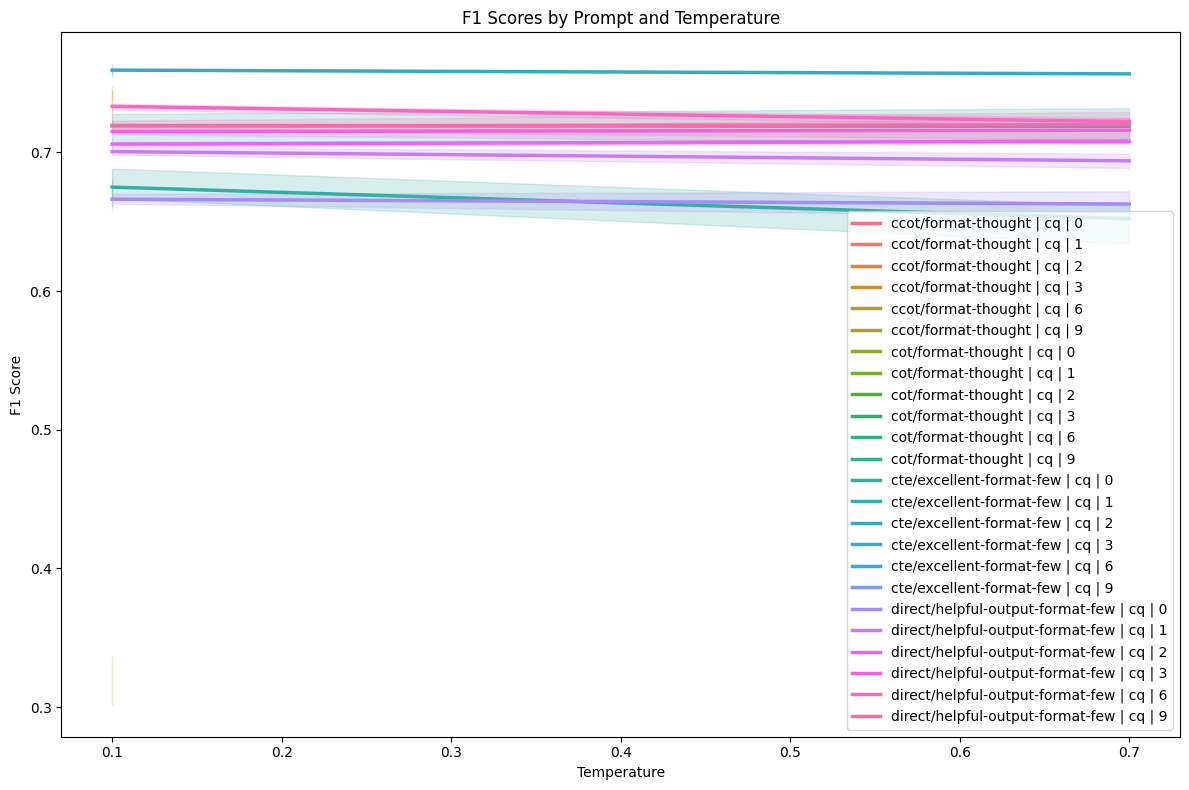

In [14]:
plot_variance(prepared_df, legend_loc='lower right')

## Statistical Testing

In [15]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [16]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    # Two-Way ANOVA
    two_way_anova(dataf)
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

### Direct technique

In [17]:
direct_prompt_mask = prepared_df["technique"] == "Direct"
direct_prompt_prepared_df = prepared_df[direct_prompt_mask & temperature_mask]
direct_prompt_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,temperature,run,exact_match,f1,prompt


/tmp/ipykernel_20164/1498832818.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=legend_loc)


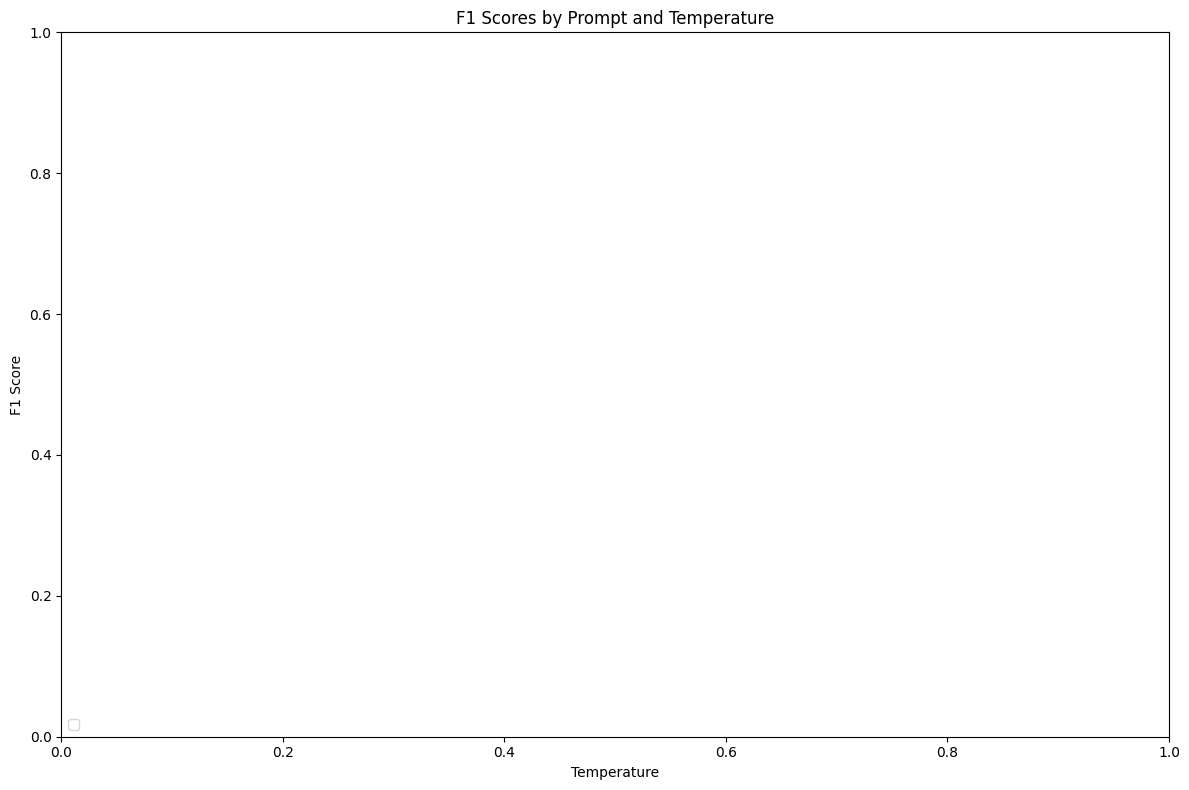

In [18]:
plot_variance(direct_prompt_prepared_df, legend='brief')

In [19]:
report(direct_prompt_prepared_df)

Prompt values


Temperature values:  




ValueError: No data to perform ANOVA

In [20]:
# Tukey’s HSD
_data = direct_prompt_prepared_df.loc[~zero_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                        group1                                                group2                        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------
direct/helpful-output-format-few | cq | direct-2-shot direct/minimal-output-format-few | cq | direct-2-shot  -0.0046 0.0001 -0.0076 -0.0017   True
--------------------------------------------------------------------------------------------------------------------------------------------------


## COT

In [21]:
cot_prompt_mask = prepared_df["technique"] == "COT"
cot_prompt_prepared_df = prepared_df[cot_prompt_mask & temperature_mask]

In [22]:
cot_prompt_prepared_df.groupby("prompt")["f1"].mean().sort_values(ascending=False)

prompt
cot/format-minimal | cq | cot-2-shot    0.642610
cot/format-think | cq | cot-2-shot      0.620965
Name: f1, dtype: float64

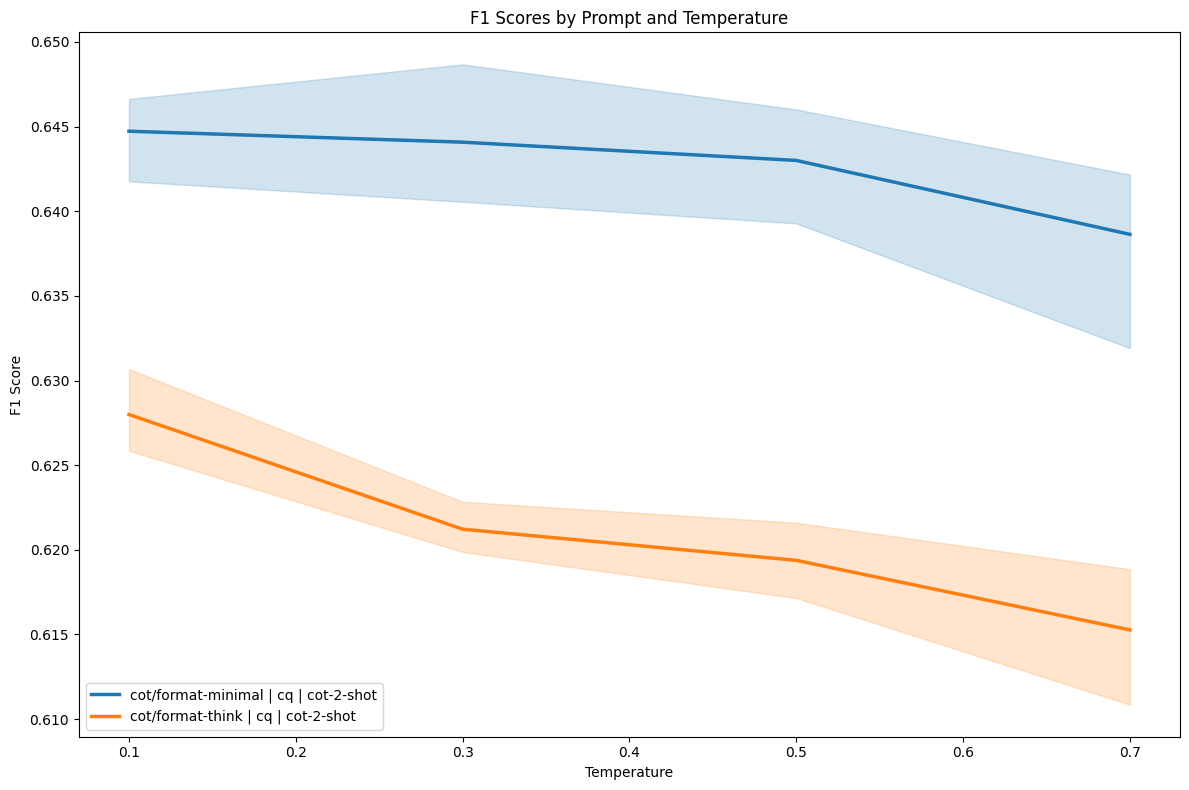

In [23]:
plot_variance(cot_prompt_prepared_df)

In [24]:
report(cot_prompt_prepared_df)

Prompt values
	 cot/format-minimal | cq | cot-2-shot
	 cot/format-think | cq | cot-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df           F        PR(>F)
C(prompt)                 0.002811   1.0  196.163292  2.127032e-10
C(temperature)            0.000272   3.0    6.335496  4.895635e-03
C(prompt):C(temperature)  0.000049   3.0    1.133180  3.654333e-01
Residual                  0.000229  16.0         NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 65.7285, p-value: 1.2584e-03
One-Way ANOVA for Temperature 0.3:
F-statistic: 80.0083, p-value: 8.6404e-04
One-Way ANOVA for Temperature 0.5:
F-statistic: 100.5328, p-value: 5.5625e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 24.9605, p-value: 7.5114e-03


                            Multiple Comparison of Means - Tukey HSD, FWER=0.01                             
               group1                              group2               meandiff p-adj

### All techniques

In [25]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_data = _data.loc[prompt_mask&temperature_mask]
best_prepared_data

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
12,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.1,1,0.610261,0.719511,ccot/format-thought | cq | ccot-2-shot-thought
13,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.1,3,0.607778,0.718106,ccot/format-thought | cq | ccot-2-shot-thought
14,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.3,1,0.604882,0.717042,ccot/format-thought | cq | ccot-2-shot-thought
15,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.3,2,0.605296,0.719131,ccot/format-thought | cq | ccot-2-shot-thought
16,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.3,3,0.610261,0.721803,ccot/format-thought | cq | ccot-2-shot-thought
17,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,1,0.613571,0.721371,ccot/format-thought | cq | ccot-2-shot-thought
18,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,2,0.607778,0.719352,ccot/format-thought | cq | ccot-2-shot-thought
19,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.5,3,0.608606,0.719260,ccot/format-thought | cq | ccot-2-shot-thought
20,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.7,1,0.604055,0.715808,ccot/format-thought | cq | ccot-2-shot-thought
21,CCOT,ccot/format-thought,cq,ccot-2-shot-thought,0.7,2,0.606537,0.716160,ccot/format-thought | cq | ccot-2-shot-thought


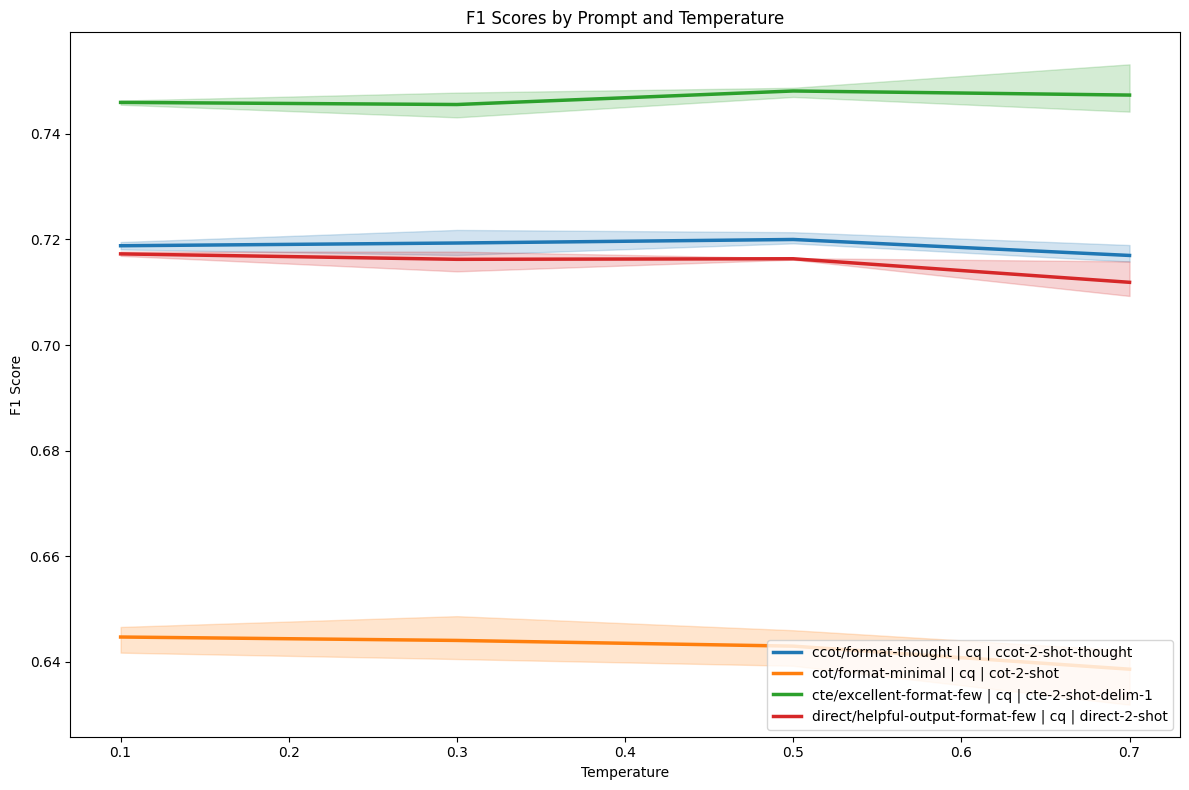

In [26]:
plot_variance(best_prepared_data, figsize=(12, 8), legend_loc='lower right')

In [27]:
report(best_prepared_data)

Prompt values
	 ccot/format-thought | cq | ccot-2-shot-thought
	 cot/format-minimal | cq | cot-2-shot
	 cte/excellent-format-few | cq | cte-2-shot-delim-1
	 direct/helpful-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df            F        PR(>F)
C(prompt)                 0.071000   3.0  2851.564401  6.306055e-38
C(temperature)            0.000079   3.0     3.167872  3.811013e-02
C(prompt):C(temperature)  0.000069   9.0     0.926631  5.160405e-01
Residual                  0.000257  31.0          NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 2580.2626, p-value: 5.1593e-11
One-Way ANOVA for Temperature 0.3:
F-statistic: 698.0547, p-value: 5.1539e-10
One-Way ANOVA for Temperature 0.5:
F-statistic: 1712.9478, p-value: 1.4356e-11
One-Way ANOVA for Temperature 0.7:
F-statistic: 343.0316, p-value: 8.6865e-09


                                              Multiple Compariso

## Inspect

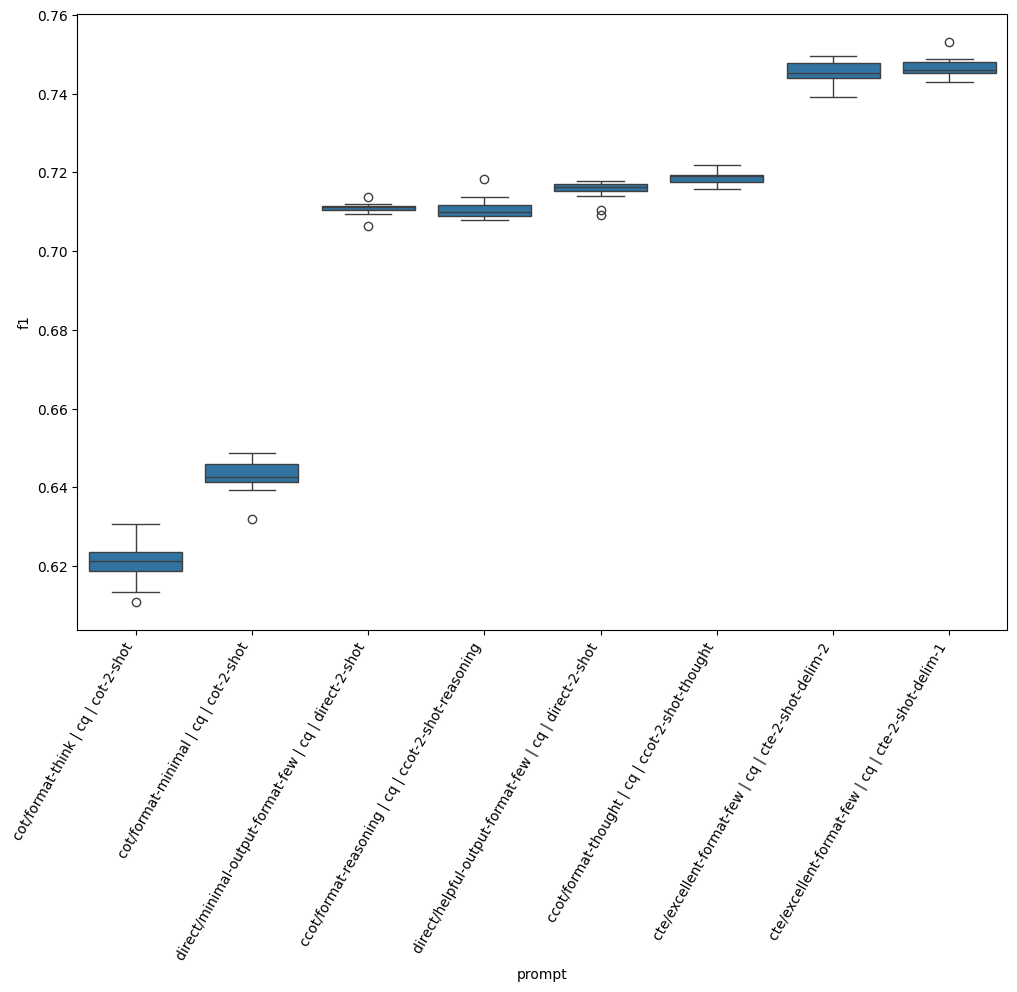

In [28]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=60, ha="right");